FULL FREQUENCY RANGE
Freq min: 0.01 Hz
Freq max: 1.27 Hz
Beta: -0.08
H: 0.54
SELECTED FREQUENCY RANGE
Freq min: 0.11 Hz
Freq max: 0.2 Hz
Beta: -0.11
H: 0.56


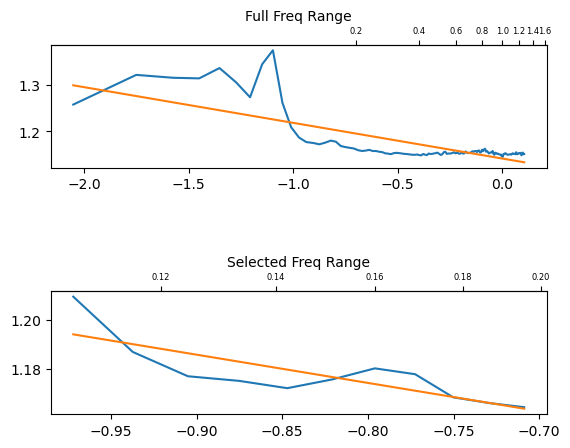

In [18]:
##############################################################################
# This notebook displays the PSD for the full frequency range and a selected
# frequency range in order to identify the frequency range over which power law 
# scaling exists. 

# INPUTS
# "bold" is the filename that you want to see the PSD for (.nii.gz file)
# "min_freq" is the minimum value in the desired frequency range
# "max_freq" is the maximum value in the desired frequency range

# OUTPUTS
# print statements of the frequency range, beta value, and hurst exponenet
# for the full and selected frequncy ranges
# plots of the full frequnecy range and selected frequency range PSDs
# each plot is log(freq) vs. log(power), but the freq values are on the top axis
# for easier conversion between log and normal frequency values
##############################################################################

import multiprocessing
from joblib import Parallel, delayed
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
from scipy.signal import welch as welch
from sklearn.linear_model import LinearRegression
import sys
import nibabel as nib



##############################################################################
# INPUTS (user change accordingly)
##############################################################################

bold = 'dhcpsample/sub-CC01004XX06_ses-51630_task-rest_desc-preproc_bold.nii.gz'
min_freq = 0.1
max_freq = 0.2

##############################################################################
# LOAD BOLD SIGNAL
##############################################################################

slice_img = nib.load(bold, mmap=False)
n1_header = slice_img.header
TR = n1_header.get_zooms()
TR = np.asarray(TR)[3]
slice_array = slice_img.get_fdata()
[N1, N2, slice_num, N3] = slice_array.shape
row = np.arange(N1)
column = np.arange(N2)

##############################################################################
# CALCULATE FREQUENCY VECTOR FOR DATA
##############################################################################

samp_slice = slice_array[:,:,slice_num-1,:]
vox = (samp_slice[N1-1,N2-1])
nperseg = math.floor(len(vox)/8)
noverlap = math.floor(nperseg/2)
w = welch(vox, fs = 1/TR, nperseg = nperseg, noverlap = noverlap)
np.seterr(divide = 'ignore')
freq=w[0]

##############################################################################
# CALCULATE PSD FOR EACH VOXEL USING MULTIPROCESSOR FOR LOOP
##############################################################################

def PSD_voxel(i,j):
    '''calculates the power spectrum of one voxel using Welchs method'''
    global TR 
    global freq
    voxel = (slice_sq[i,j])
    if np.mean(voxel) == 0:
        return np.zeros(len(freq))
    else:
        nperseg = math.floor(len(voxel)/8)
        noverlap = math.floor(nperseg/2)
        w = welch(voxel, fs = TR, nperseg = nperseg, noverlap = noverlap)
        np.seterr(divide = 'ignore')
        power=w[1]
        return power


num_cores = multiprocessing.cpu_count()
tot = np.zeros(len(freq))
count = 0
for x in range(slice_num):
    slice_sq = slice_array[:,:,x,:]
    out = Parallel(n_jobs=num_cores)(delayed(PSD_voxel)(i,j) for i in row for j in column)
    out = np.array(out, dtype=object) 
    for x in np.arange(len(out)):
        tot = tot + out[x]
        if np.mean(out[x]) == 0:
            pass
        else:
            count = count+1
            tot = tot + out[x]
            
##############################################################################
# CALCULATE AVERAGE POWER SPECTRA FOR ALL VOXELS
##############################################################################

avg=tot/count
avg = avg.astype(float)

##############################################################################
# PLOT AVERAGE PSD FOR FULL FREQUENCY
##############################################################################

x = np.log10(freq)[1:].reshape((-1, 1))
y = np.log10(avg)[1:]
fig, ax = plt.subplots(2)
ax[0].plot(x,y)

##############################################################################
# CALCULATE BETA AND HURST EXPONENT
############################################################################## 

model = LinearRegression().fit(x, y)
negbeta = model.coef_
beta = negbeta*-1
beta = negbeta*-1
H = (beta + 1)/2
H = H[0]
H = round(H, 2)
negbeta = round(negbeta[0], 2)

##############################################################################
# PLOT LINEAR REGRESSION LINE (BETA)
##############################################################################

x_new=x
y_new=model.predict(x)
ax[0].plot(x_new, y_new)
minfreq = np.power(10,x)[0]
minfreq = minfreq[0]
minfreq = round(minfreq, 2)
maxfreq = np.power(10,x)[-1]
maxfreq = maxfreq[0]
maxfreq = round(maxfreq, 2)

##############################################################################
# FULL FREQUENCIES PRINT STATMENTS
##############################################################################

print("FULL FREQUENCY RANGE")
print("Freq min: %s Hz" % (minfreq))
print("Freq max: %s Hz" % (maxfreq))
print("Beta: %s" % (negbeta))
print("H: %s" % (H))

##############################################################################
# PLOT SELECTED FREQUENCIES 
##############################################################################

freq_arr = np.power(10,x)
max_ind = np.where(freq_arr > max_freq)[0][0]
min_ind = np.where(freq_arr < min_freq)[0][-1] + 1
freq_sel = freq_arr[min_ind:max_ind]
power_sel = avg[min_ind:max_ind]
x = np.log10(freq_sel).reshape((-1, 1))
y = np.log10(power_sel)
ax[1].plot(x,y)
model = LinearRegression().fit(x, y)

##############################################################################
# CALCULATE BETA AND HURST EXPONENT
##############################################################################

negbeta = model.coef_
beta = negbeta*-1
H = (beta + 1)/2
H = H[0]
H = round(H, 2)
negbeta = round(negbeta[0], 2)

##############################################################################
# PLOT LINEAR REGRESSION LINE (BETA)
##############################################################################

x_new=x
y_new=model.predict(x)
ax[1].plot(x_new, y_new)
minfreq = np.power(10,x)[0]
minfreq = minfreq[0]
minfreq = round(minfreq, 2)
maxfreq = np.power(10,x)[-1]
maxfreq = maxfreq[0]
maxfreq = round(maxfreq, 2)

##############################################################################
# ADD SECONDARY AXIS FOR FREQUENCY ON SUBPLOTS & TITLES
##############################################################################

def log(x):
    return np.log10(x)

def power(x):
    return np.power(10,x)

ax1 = ax[0].secondary_xaxis('top', functions=(power, log))
ax2 = ax[1].secondary_xaxis('top', functions=(power, log))
ax1.xaxis.set_tick_params(labelsize=6)
ax2.xaxis.set_tick_params(labelsize=6)

fig.subplots_adjust(hspace=1)
ax1.set_xlabel('Full Freq Range')
ax2.set_xlabel('Selected Freq Range')

##############################################################################
# SELECTED FREQUENCIES PRINT STATEMENTS
##############################################################################

print("SELECTED FREQUENCY RANGE")
print("Freq min: %s Hz" % (minfreq))
print("Freq max: %s Hz" % (maxfreq))
print("Beta: %s" % (negbeta))
print("H: %s" % (H))

fig